# Method 8 - Best Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

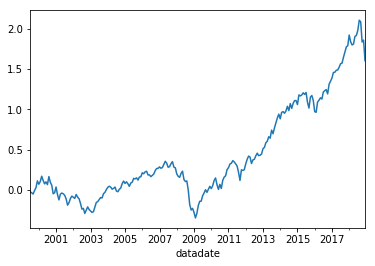

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.110723
2000-12-31   -0.132945
2001-12-31   -0.043451
2002-12-31   -0.181927
2003-12-31    0.329944
2004-12-31    0.105687
2005-12-31    0.047638
2006-12-31    0.090667
2007-12-31    0.005334
2008-12-31   -0.396033
2009-12-31    0.356371
2010-12-31    0.198739
2011-12-31   -0.000731
2012-12-31    0.155643
2013-12-31    0.344052
2014-12-31    0.087110
2015-12-31    0.000634
2016-12-31    0.113429
2017-12-31    0.188030
2018-12-31   -0.066750
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2355.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.09e-184
Time:                        06:32:21   Log-Likelihood:                 839.36
No. Observations:                 234   AIC:                            -1669.
Df Residuals:                     229   BIC:                            -1651.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.037      0.043    3.07e-05       0.002
mktrf          0.9575      0.013     75.822      0.000       0.933       0.982
me             0.0874      0.015      5.947      0.000       0.058       0.116
ia            -0.0068      0.022     -0.303      0.762      -0.051       0.037
roe           -0.0100      0.019     -0.523      0.602      -0.048       0.028
==============================================================================
Omnibus:                       65.724   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.991
Skew:                           0.845   Prob(JB):                    5.98e-110
Kurtosis:                       9.981   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     4214.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.24e-213
Time:                        06:32:21   Log-Likelihood:                 839.36
No. Observations:                 234   AIC:                            -1669.
Df Residuals:                     229   BIC:                            -1651.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.821      0.069   -7.18e-05       0.002
mktrf          0.9575      0.020     46.761      0.000       0.917       0.998
me             0.0874      0.048      1.833      0.067      -0.006       0.181
ia            -0.0068      0.037     -0.181      0.857      -0.080       0.067
roe           -0.0100      0.038     -0.265      0.791      -0.084       0.064
==============================================================================
Omnibus:                       65.724   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.991
Skew:                           0.845   Prob(JB):                    5.98e-110
Kurtosis:                       9.981   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     5152.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.71e-223
Time:                        06:32:21   Log-Likelihood:                 839.36
No. Observations:                 234   AIC:                            -1669.
Df Residuals:                     229   BIC:                            -1651.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.794      0.073   -8.71e-05       0.002
mktrf          0.9575      0.017     56.128      0.000       0.924       0.991
me             0.0874      0.051      1.709      0.087      -0.013       0.188
ia            -0.0068      0.030     -0.223      0.824      -0.066       0.053
roe           -0.0100      0.033     -0.303      0.762      -0.075       0.055
==============================================================================
Omnibus:                       65.724   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.991
Skew:                           0.845   Prob(JB):                    5.98e-110
Kurtosis:                       9.981   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1901.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.29e-183
Time:                        06:32:21   Log-Likelihood:                 840.87
No. Observations:                 234   AIC:                            -1670.
Df Residuals:                     228   BIC:                            -1649.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.350      0.178      -0.000       0.002
mktrf          0.9639      0.013     76.508      0.000       0.939       0.989
smb            0.1336      0.017      8.034      0.000       0.101       0.166
hml            0.0476      0.020      2.428      0.016       0.009       0.086
rmw            0.0391      0.022      1.764      0.079      -0.005       0.083
cma           -0.0969      0.028     -3.439      0.001      -0.152      -0.041
==============================================================================
Omnibus:                       64.150   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.853
Skew:                           0.792   Prob(JB):                    1.07e-114
Kurtosis:                      10.164   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1869.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.43e-183
Time:                        06:32:21   Log-Likelihood:                 840.87
No. Observations:                 234   AIC:                            -1670.
Df Residuals:                     228   BIC:                            -1649.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.215      0.224      -0.000       0.002
mktrf          0.9639      0.017     57.356      0.000       0.931       0.997
smb            0.1336      0.039      3.444      0.001       0.058       0.210
hml            0.0476      0.038      1.263      0.207      -0.026       0.121
rmw            0.0391      0.025      1.578      0.114      -0.009       0.088
cma           -0.0969      0.041     -2.346      0.019      -0.178      -0.016
==============================================================================
Omnibus:                       64.150   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.853
Skew:                           0.792   Prob(JB):                    1.07e-114
Kurtosis:                      10.164   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2443.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.66e-196
Time:                        06:32:21   Log-Likelihood:                 840.87
No. Observations:                 234   AIC:                            -1670.
Df Residuals:                     228   BIC:                            -1649.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.173      0.241      -0.000       0.002
mktrf          0.9639      0.017     56.672      0.000       0.931       0.997
smb            0.1336      0.038      3.482      0.000       0.058       0.209
hml            0.0476      0.035      1.374      0.169      -0.020       0.115
rmw            0.0391      0.023      1.736      0.083      -0.005       0.083
cma           -0.0969      0.035     -2.769      0.006      -0.165      -0.028
==============================================================================
Omnibus:                       64.150   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.853
Skew:                           0.792   Prob(JB):                    1.07e-114
Kurtosis:                      10.164   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2323.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.04e-184
Time:                        06:32:21   Log-Likelihood:                 837.79
No. Observations:                 234   AIC:                            -1666.
Df Residuals:                     229   BIC:                            -1648.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      1.996      0.047    1.17e-05       0.002
mktrf          0.9468      0.012     80.886      0.000       0.924       0.970
smb            0.1147      0.015      7.851      0.000       0.086       0.143
hml            0.0320      0.015      2.204      0.029       0.003       0.061
umd           -0.0391      0.010     -4.108      0.000      -0.058      -0.020
==============================================================================
Omnibus:                       44.204   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.274
Skew:                           0.561   Prob(JB):                     4.05e-53
Kurtosis:                       7.847   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     3094.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.46e-198
Time:                        06:32:21   Log-Likelihood:                 837.79
No. Observations:                 234   AIC:                            -1666.
Df Residuals:                     229   BIC:                            -1648.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.709      0.087      -0.000       0.002
mktrf          0.9468      0.016     58.002      0.000       0.915       0.979
smb            0.1147      0.040      2.867      0.004       0.036       0.193
hml            0.0320      0.021      1.538      0.124      -0.009       0.073
umd           -0.0391      0.020     -1.917      0.055      -0.079       0.001
==============================================================================
Omnibus:                       44.204   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.274
Skew:                           0.561   Prob(JB):                     4.05e-53
Kurtosis:                       7.847   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     3641.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.07e-206
Time:                        06:32:21   Log-Likelihood:                 837.79
No. Observations:                 234   AIC:                            -1666.
Df Residuals:                     229   BIC:                            -1648.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.619      0.105      -0.000       0.002
mktrf          0.9468      0.016     59.259      0.000       0.915       0.978
smb            0.1147      0.038      3.015      0.003       0.040       0.189
hml            0.0320      0.021      1.549      0.121      -0.008       0.072
umd           -0.0391      0.020     -2.002      0.045      -0.077      -0.001
==============================================================================
Omnibus:                       44.204   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.274
Skew:                           0.561   Prob(JB):                     4.05e-53
Kurtosis:                       7.847   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     991.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.35e-88
Time:                        06:32:21   Log-Likelihood:                 407.26
No. Observations:                 120   AIC:                            -804.5
Df Residuals:                     115   BIC:                            -790.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.759      0.081      -0.000       0.003
mktrf          0.9571      0.021     44.738      0.000       0.915       0.999
me             0.0523      0.021      2.473      0.015       0.010       0.094
ia             0.0023      0.033      0.071      0.944      -0.063       0.068
roe           -0.0207      0.029     -0.708      0.481      -0.079       0.037
==============================================================================
Omnibus:                       32.812   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.980
Skew:                           0.907   Prob(JB):                     1.31e-24
Kurtosis:                       7.325   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2226.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.83e-108
Time:                        06:32:21   Log-Likelihood:                 407.26
No. Observations:                 120   AIC:                            -804.5
Df Residuals:                     115   BIC:                            -790.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.426      0.154      -0.001       0.003
mktrf          0.9571      0.028     34.313      0.000       0.902       1.012
me             0.0523      0.051      1.017      0.309      -0.048       0.153
ia             0.0023      0.046      0.051      0.959      -0.088       0.093
roe           -0.0207      0.051     -0.406      0.684      -0.121       0.079
==============================================================================
Omnibus:                       32.812   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.980
Skew:                           0.907   Prob(JB):                     1.31e-24
Kurtosis:                       7.325   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     3444.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.12e-118
Time:                        06:32:21   Log-Likelihood:                 407.26
No. Observations:                 120   AIC:                            -804.5
Df Residuals:                     115   BIC:                            -790.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.254      0.210      -0.001       0.004
mktrf          0.9571      0.020     48.001      0.000       0.918       0.996
me             0.0523      0.056      0.931      0.352      -0.058       0.162
ia             0.0023      0.038      0.061      0.951      -0.073       0.078
roe           -0.0207      0.043     -0.482      0.630      -0.105       0.064
==============================================================================
Omnibus:                       32.812   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.980
Skew:                           0.907   Prob(JB):                     1.31e-24
Kurtosis:                       7.325   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     711.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.63e-84
Time:                        06:32:21   Log-Likelihood:                 401.45
No. Observations:                 120   AIC:                            -790.9
Df Residuals:                     114   BIC:                            -774.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.569      0.119      -0.000       0.003
mktrf          0.9957      0.024     41.869      0.000       0.949       1.043
smb            0.1211      0.027      4.495      0.000       0.068       0.174
hml            0.0215      0.033      0.651      0.516      -0.044       0.087
rmw            0.0720      0.039      1.851      0.067      -0.005       0.149
cma           -0.0695      0.043     -1.629      0.106      -0.154       0.015
==============================================================================
Omnibus:                       21.368   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.809
Skew:                           0.526   Prob(JB):                     1.14e-15
Kurtosis:                       6.557   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     818.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-87
Time:                        06:32:21   Log-Likelihood:                 401.45
No. Observations:                 120   AIC:                            -790.9
Df Residuals:                     114   BIC:                            -774.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.417      0.157      -0.001       0.003
mktrf          0.9957      0.029     34.766      0.000       0.940       1.052
smb            0.1211      0.053      2.277      0.023       0.017       0.225
hml            0.0215      0.055      0.392      0.695      -0.086       0.129
rmw            0.0720      0.046      1.556      0.120      -0.019       0.163
cma           -0.0695      0.059     -1.175      0.240      -0.185       0.046
==============================================================================
Omnibus:                       21.368   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.809
Skew:                           0.526   Prob(JB):                     1.14e-15
Kurtosis:                       6.557   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1188.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.54e-96
Time:                        06:32:21   Log-Likelihood:                 401.45
No. Observations:                 120   AIC:                            -790.9
Df Residuals:                     114   BIC:                            -774.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.317      0.188      -0.001       0.003
mktrf          0.9957      0.030     33.143      0.000       0.937       1.055
smb            0.1211      0.052      2.314      0.021       0.019       0.224
hml            0.0215      0.052      0.411      0.681      -0.081       0.124
rmw            0.0720      0.047      1.520      0.128      -0.021       0.165
cma           -0.0695      0.049     -1.418      0.156      -0.166       0.027
==============================================================================
Omnibus:                       21.368   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.809
Skew:                           0.526   Prob(JB):                     1.14e-15
Kurtosis:                       6.557   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     899.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.67e-86
Time:                        06:32:21   Log-Likelihood:                 401.62
No. Observations:                 120   AIC:                            -793.2
Df Residuals:                     115   BIC:                            -779.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.280      0.024       0.000       0.003
mktrf          0.9533      0.020     48.256      0.000       0.914       0.992
smb            0.0959      0.022      4.264      0.000       0.051       0.140
hml            0.0345      0.023      1.530      0.129      -0.010       0.079
umd           -0.0446      0.014     -3.210      0.002      -0.072      -0.017
==============================================================================
Omnibus:                        9.760   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               19.334
Skew:                           0.234   Prob(JB):                     6.33e-05
Kurtosis:                       4.910   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1235.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.96e-93
Time:                        06:32:21   Log-Likelihood:                 401.62
No. Observations:                 120   AIC:                            -793.2
Df Residuals:                     115   BIC:                            -779.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.156      0.031       0.000       0.004
mktrf          0.9533      0.025     37.507      0.000       0.903       1.003
smb            0.0959      0.045      2.113      0.035       0.007       0.185
hml            0.0345      0.027      1.298      0.194      -0.018       0.087
umd           -0.0446      0.023     -1.963      0.050      -0.089   -7.54e-05
==============================================================================
Omnibus:                        9.760   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               19.334
Skew:                           0.234   Prob(JB):                     6.33e-05
Kurtosis:                       4.910   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1418.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.96e-97
Time:                        06:32:21   Log-Likelihood:                 401.62
No. Observations:                 120   AIC:                            -793.2
Df Residuals:                     115   BIC:                            -779.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.988      0.047    2.58e-05       0.004
mktrf          0.9533      0.025     37.727      0.000       0.904       1.003
smb            0.0959      0.042      2.270      0.023       0.013       0.179
hml            0.0345      0.027      1.286      0.198      -0.018       0.087
umd           -0.0446      0.020     -2.198      0.028      -0.084      -0.005
==============================================================================
Omnibus:                        9.760   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               19.334
Skew:                           0.234   Prob(JB):                     6.33e-05
Kurtosis:                       4.910   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2343.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.10e-104
Time:                        06:32:21   Log-Likelihood:                 469.10
No. Observations:                 114   AIC:                            -928.2
Df Residuals:                     109   BIC:                            -914.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.243      0.027       0.000       0.002
mktrf          0.9347      0.012     78.683      0.000       0.911       0.958
me             0.1929      0.018     10.515      0.000       0.157       0.229
ia            -0.0456      0.025     -1.791      0.076      -0.096       0.005
roe           -0.0018      0.022     -0.080      0.936      -0.046       0.043
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.001
Skew:                           0.004   Prob(JB):                         1.00
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2866.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.11e-109
Time:                        06:32:21   Log-Likelihood:                 469.10
No. Observations:                 114   AIC:                            -928.2
Df Residuals:                     109   BIC:                            -914.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.425      0.015       0.000       0.002
mktrf          0.9347      0.012     78.697      0.000       0.911       0.958
me             0.1929      0.017     11.190      0.000       0.159       0.227
ia            -0.0456      0.034     -1.349      0.177      -0.112       0.021
roe           -0.0018      0.019     -0.094      0.925      -0.039       0.035
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.001
Skew:                           0.004   Prob(JB):                         1.00
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3981.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.06e-117
Time:                        06:32:21   Log-Likelihood:                 469.10
No. Observations:                 114   AIC:                            -928.2
Df Residuals:                     109   BIC:                            -914.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      3.109      0.002       0.000       0.001
mktrf          0.9347      0.011     86.124      0.000       0.913       0.956
me             0.1929      0.016     12.045      0.000       0.161       0.224
ia            -0.0456      0.034     -1.335      0.182      -0.112       0.021
roe           -0.0018      0.019     -0.094      0.925      -0.039       0.036
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.001
Skew:                           0.004   Prob(JB):                         1.00
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3367.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.42e-117
Time:                        06:32:21   Log-Likelihood:                 502.72
No. Observations:                 114   AIC:                            -993.4
Df Residuals:                     108   BIC:                            -977.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.731      0.466      -0.000       0.001
mktrf          0.9333      0.008    110.131      0.000       0.917       0.950
smb            0.1696      0.014     12.331      0.000       0.142       0.197
hml            0.0362      0.018      2.065      0.041       0.001       0.071
rmw           -0.0380      0.021     -1.767      0.080      -0.081       0.005
cma           -0.1121      0.027     -4.112      0.000      -0.166      -0.058
==============================================================================
Omnibus:                        0.469   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.606
Skew:                           0.130   Prob(JB):                        0.739
Kurtosis:                       2.756   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3270.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.05e-116
Time:                        06:32:21   Log-Likelihood:                 502.72
No. Observations:                 114   AIC:                            -993.4
Df Residuals:                     108   BIC:                            -977.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.692      0.489      -0.000       0.001
mktrf          0.9333      0.009    100.889      0.000       0.915       0.951
smb            0.1696      0.010     16.561      0.000       0.150       0.190
hml            0.0362      0.016      2.235      0.025       0.004       0.068
rmw           -0.0380      0.021     -1.769      0.077      -0.080       0.004
cma           -0.1121      0.026     -4.371      0.000      -0.162      -0.062
==============================================================================
Omnibus:                        0.469   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.606
Skew:                           0.130   Prob(JB):                        0.739
Kurtosis:                       2.756   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     5710.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.00e-129
Time:                        06:32:21   Log-Likelihood:                 502.72
No. Observations:                 114   AIC:                            -993.4
Df Residuals:                     108   BIC:                            -977.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.642      0.521      -0.000       0.001
mktrf          0.9333      0.010     97.250      0.000       0.915       0.952
smb            0.1696      0.010     17.286      0.000       0.150       0.189
hml            0.0362      0.014      2.607      0.009       0.009       0.063
rmw           -0.0380      0.025     -1.544      0.123      -0.086       0.010
cma           -0.1121      0.024     -4.657      0.000      -0.159      -0.065
==============================================================================
Omnibus:                        0.469   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.606
Skew:                           0.130   Prob(JB):                        0.739
Kurtosis:                       2.756   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3521.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.10e-114
Time:                        06:32:21   Log-Likelihood:                 492.10
No. Observations:                 114   AIC:                            -974.2
Df Residuals:                     109   BIC:                            -960.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.386e-05      0.000     -0.073      0.942      -0.001       0.001
mktrf          0.9399      0.009    102.162      0.000       0.922       0.958
smb            0.1796      0.014     12.521      0.000       0.151       0.208
hml            0.0101      0.015      0.684      0.495      -0.019       0.039
umd           -0.0002      0.011     -0.022      0.983      -0.022       0.022
==============================================================================
Omnibus:                        0.515   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.773   Jarque-Bera (JB):                0.585
Skew:                           0.155   Prob(JB):                        0.747
Kurtosis:                       2.834   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     4164.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.57e-118
Time:                        06:32:21   Log-Likelihood:                 492.10
No. Observations:                 114   AIC:                            -974.2
Df Residuals:                     109   BIC:                            -960.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.386e-05      0.000     -0.076      0.939      -0.001       0.001
mktrf          0.9399      0.009    102.495      0.000       0.922       0.958
smb            0.1796      0.012     15.577      0.000       0.157       0.202
hml            0.0101      0.014      0.708      0.479      -0.018       0.038
umd           -0.0002      0.016     -0.016      0.988      -0.031       0.031
==============================================================================
Omnibus:                        0.515   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.773   Jarque-Bera (JB):                0.585
Skew:                           0.155   Prob(JB):                        0.747
Kurtosis:                       2.834   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     7592.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.54e-132
Time:                        06:32:21   Log-Likelihood:                 492.10
No. Observations:                 114   AIC:                            -974.2
Df Residuals:                     109   BIC:                            -960.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.386e-05      0.000     -0.079      0.937      -0.001       0.001
mktrf          0.9399      0.009    103.577      0.000       0.922       0.958
smb            0.1796      0.011     16.903      0.000       0.159       0.200
hml            0.0101      0.014      0.714      0.475      -0.018       0.038
umd           -0.0002      0.017     -0.014      0.989      -0.034       0.033
==============================================================================
Omnibus:                        0.515   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.773   Jarque-Bera (JB):                0.585
Skew:                           0.155   Prob(JB):                        0.747
Kurtosis:                       2.834   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""